# RL and Advanced DL: Домашнее задание 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import gym
from gym.envs.toy_text.blackjack import BlackjackEnv, cmp, usable_ace, sum_hand, is_bust, score, is_natural
plt.rcParams['figure.figsize'] = [14, 10]

### Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;

* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;

* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;

* игрок может совершать одно из двух действий:
  * hit  — взять ещё одну карту;
  * stand — не брать больше карт;  
        
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);

* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;

* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);

* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
    
Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

  1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
  
  2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
  
  3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [2]:
def simple_pi(env):
    player, dealer, usable_ace = env._get_obs()
    return np.int(player < 19)

def run_experiments(num_experiments = 100000):
    reward_total = []
    for _ in range(num_experiments):
        observation = env.reset()
        done = False
        while not done:
            observation, reward, done, info = env.step(simple_pi(env))
        reward_total.append(reward)
    return np.mean(reward_total)

env = gym.make('Blackjack-v0', natural=True)
num_experiments = 200000

print("Средний выигрыш при наивной стратегии", run_experiments(num_experiments))


Средний выигрыш при наивной стратегии -0.1826775


Воспользуемся методом Монте-Карло

In [3]:
def eps_pi(s, eps):
    if random.random() < eps:
        return random.randint(0, 1)
    act_0 = G[(s[0], s[1], s[2], 0)] if (s[0], s[1], s[2], 0) in G else [0, 1]
    act_1 = G[(s[0], s[1], s[2], 1)] if (s[0], s[1], s[2], 1) in G else [0, 1]
    return int((act_0[0] / act_0[1]) <= (act_1[0] / act_1[1]))
        
def run_episode(eps):
    states, observation, done  = [], env.reset(), False
    action = eps_pi(observation, eps)  
    state = observation[0], observation[1], observation[2], action
    states.append(state)
    while (action == 1) and not done:
        observation, reward, done, info = env.step(1)
        if done:
            break
        action = eps_pi(observation, eps)
        state = observation[0], observation[1], observation[2], action
        states.append(state)
    if not done:
        observation, reward, done, info = env.step(0)
    for s in states:
        if s not in G:
            G[s] = [0, 0]
        G[s][0] += reward
        G[s][1] += 1
    return(reward)

In [4]:
num_experiments = 300_000
points = 10
reward_total, reward_sum = {}, {}
epsilons = np.linspace(0.01,0.05,5)

for eps in epsilons:
    G = {}
    reward_total[eps], reward_sum[eps] = [], []
    for _ in range(num_experiments):
        reward_total[eps].append(run_episode(eps))
    for i in range(1, points + 1):
        reward_sum[eps].append(np.array(reward_total[eps][:i*num_experiments//points]).mean())
    print('Средний выигрыш для eps= {}: {}'.format(eps, np.mean(reward_total[eps])))

Средний выигрыш для eps= 0.01: -0.08609
Средний выигрыш для eps= 0.02: -0.067285
Средний выигрыш для eps= 0.03: -0.06313166666666667
Средний выигрыш для eps= 0.04: -0.061105
Средний выигрыш для eps= 0.05: -0.06144666666666666


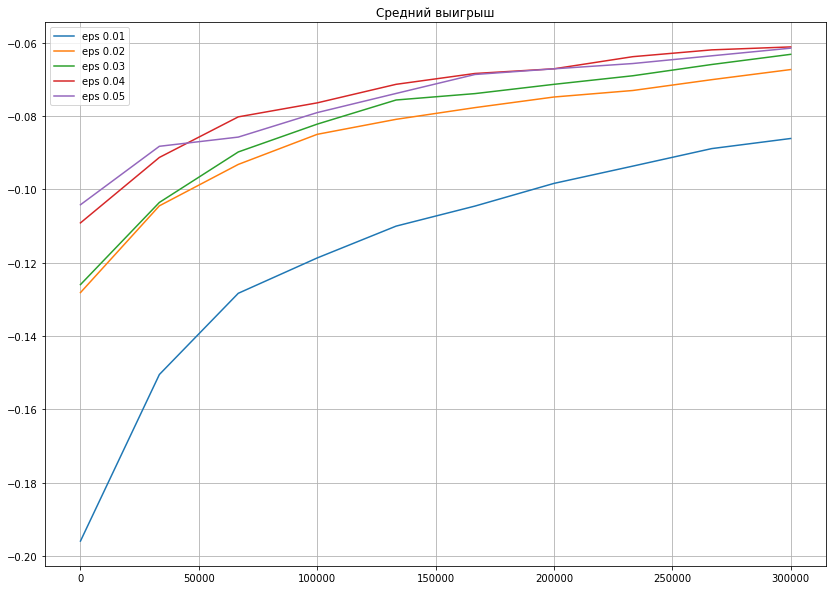

In [5]:
x = np.linspace(0, num_experiments, points)
for eps in epsilons:
    plt.plot(x, reward_sum[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Cредний выигрыш')
plt.show()

### Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [6]:
def eps_pi_double(s, eps):
    if random.random() < eps:
        return random.randint(0, 2)
    act_0 = G[(s[0], s[1], s[2], 0)] if (s[0], s[1], s[2], 0) in G else [0, 1]
    act_1 = G[(s[0], s[1], s[2], 1)] if (s[0], s[1], s[2], 1) in G else [0, 1]
    act_2 = G[(s[0], s[1], s[2], 2)] if (s[0], s[1], s[2], 2) in G else [0, 1]
    g = np.array([ act_0[0] / act_0[1], act_1[0] / act_1[1], act_2[0] / act_2[1]])
    return np.argmax(g)

def run_episode_double(eps):
    states, observation, done = [], env.reset(), False
    action = eps_pi_double(observation, eps)
    state = observation[0], observation[1], observation[2], action
    states.append(state)
    while (action != 0) and not done:
        observation, reward, done, info = env.step(1)
        if done or (action == 2):
            break
        action = eps_pi_double(observation, eps)
        state = observation[0], observation[1], observation[2], action
        states.append(state)
    if not done:
        observation, reward, done, info = env.step(0)
    if action == 2:
        reward *= 2
    for s in states:
        if s not in G:
            G[s] = [0, 0]
        G[s][0] += reward
        G[s][1] += 1
    return(reward)

In [7]:
num_experiments = 600_000
points = 10
reward_total, reward_sum = {}, {}
epsilons = np.linspace(0.01,0.05,5)

for eps in epsilons:
    G = {}
    reward_total[eps], reward_sum[eps] = [], []
    for _ in range(num_experiments):
        reward_total[eps].append(run_episode_double(eps))
    for i in range(1, points + 1):
        reward_sum[eps].append(np.mean(reward_total[eps][:i * num_experiments // points]))
    print('Средний выигрыш для eps = {}: {}'.format(eps, np.mean(reward_total[eps])))

Средний выигрыш для eps = 0.01: -0.06888583333333333
Средний выигрыш для eps = 0.02: -0.06779583333333333
Средний выигрыш для eps = 0.03: -0.06293666666666667
Средний выигрыш для eps = 0.04: -0.06913416666666666
Средний выигрыш для eps = 0.05: -0.06575416666666667


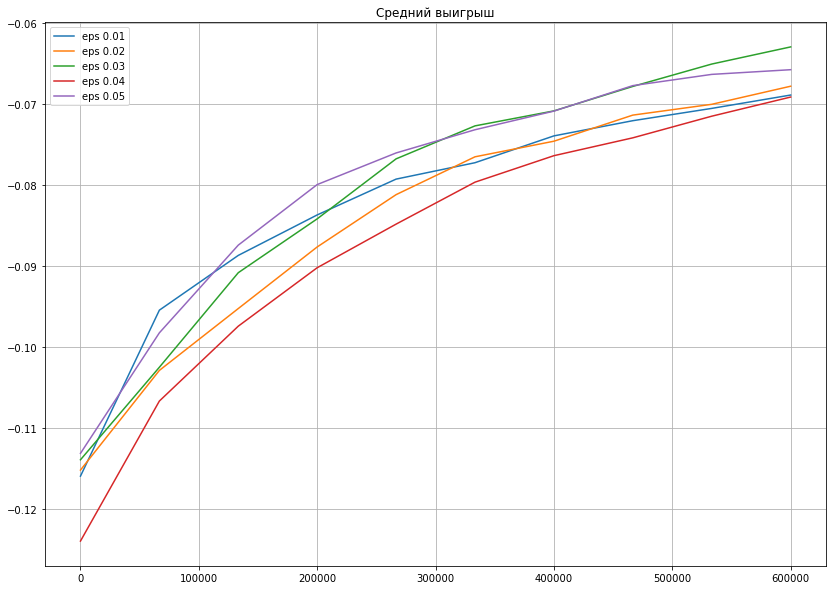

In [8]:
x = np.linspace(0, num_experiments, points)
for eps in epsilons:
    plt.plot(x, reward_sum[eps], label='eps ' + str(eps))
plt.grid()
plt.title('Cредний выигрыш')
plt.legend()
plt.show()

### Часть третья, в главной роли — Дастин Хоффман

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) о блекджеке (а возможно, и нет).

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [9]:
from blackjack import BlackjackEnvCount, draw_card, draw_hand, counter_dict, counter, deck

In [10]:
def pi_with_count(s, eps):
    if random.random() < eps:
        return random.randint(0, 2)
    act_0 = G[(s[0], s[1], s[2], counter, 0)] if (s[0], s[1], s[2], counter, 0) in G else [0, 1]
    act_1 = G[(s[0], s[1], s[2], counter, 1)] if (s[0], s[1], s[2], counter, 1) in G else [0, 1]
    act_2 = G[(s[0], s[1], s[2], counter, 2)] if (s[0], s[1], s[2], counter, 2) in G else [0, 1]
    g = np.array([ act_0[0] / act_0[1], act_1[0] / act_1[1], act_2[0] / act_2[1]])
    return np.argmax(g)

def run_episode_with_count(eps):
    states, observation, done  = [], env.reset(), False
    action = pi_with_count(observation, eps)
    state = observation[0], observation[1], observation[2], counter, action
    states.append(state)
    while (action != 0) and not done:
        observation, reward, done, info = env.step(1)
        if done or (action == 2):
            break
        action = pi_with_count(observation, eps)
        state = observation[0], observation[1], observation[2], counter, action
        states.append(state)
    if not done:
        observation, reward, done, info = env.step(0)
    if action == 2:
        reward *= 2
    for s in states:
        if s not in G:
            G[s] = [0, 0]
        G[s][0] += reward
        G[s][1] += 1
    return(reward)

In [11]:
env = BlackjackEnvCount()
points = 10
num_experiments = 1_500_000

reward_total, reward_sum = {}, {}
epsilons = np.linspace(0.01,0.05,5)

for eps in epsilons:
    G = {}
    reward_total[eps], reward_sum[eps] = [], []
    #with alive_bar(num_experiments) as bar:
    for _ in range(num_experiments):
        reward_total[eps].append(run_episode_with_count(eps))

    for i in range(1, points + 1):
        reward_sum[eps].append(np.array(reward_total[eps][:i*num_experiments//points]).mean())
    print('Средний выигрыш для eps= {}: {}'.format(eps, np.mean(reward_total[eps])))

Средний выигрыш для eps= 0.01: -0.06913866666666667
Средний выигрыш для eps= 0.02: -0.06311466666666667
Средний выигрыш для eps= 0.03: -0.068076
Средний выигрыш для eps= 0.04: -0.06776266666666667
Средний выигрыш для eps= 0.05: -0.07355266666666667


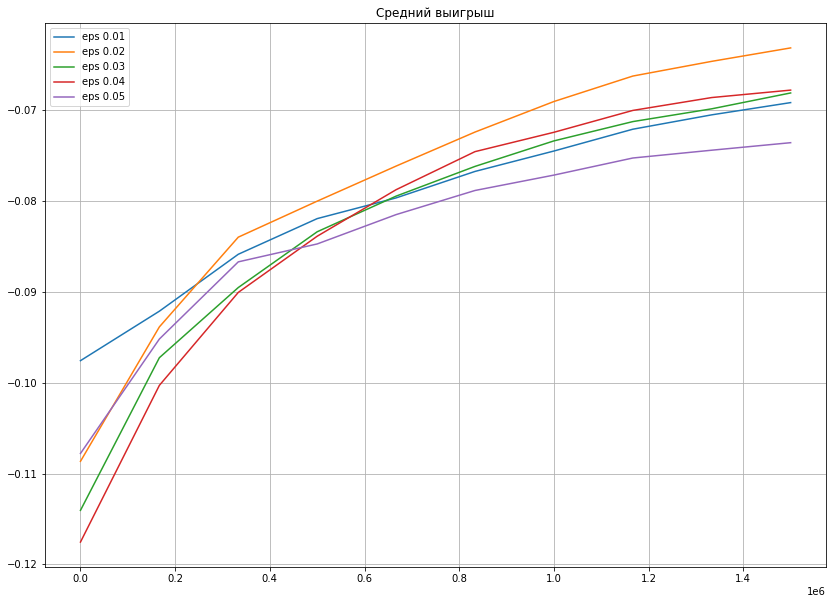

In [12]:
points = 10
x = np.linspace(0, num_experiments, points)
for eps in epsilons:
    plt.plot(x, reward_sum[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Cредний выигрыш')
plt.show()

Построим график для большего числа экспериментов при $\epsilon = 0.02$

In [13]:
points = 10
num_experiments = 50_000_000

reward_total, reward_sum = {}, {}
epsilons = [0.02]

for eps in epsilons:
    G = {}
    reward_total[eps], reward_sum[eps] = [], []
    for _ in range(num_experiments):
        reward_total[eps].append(run_episode_with_count(eps))
    for i in range(1, points + 1):
        reward_sum[eps].append(np.mean(reward_total[eps][:i*num_experiments//points]))
    print('Средний выигрыш для eps= {}: {}'.format(eps, np.mean(reward_total[eps])))

Средний выигрыш для eps= 0.02: -0.0408618


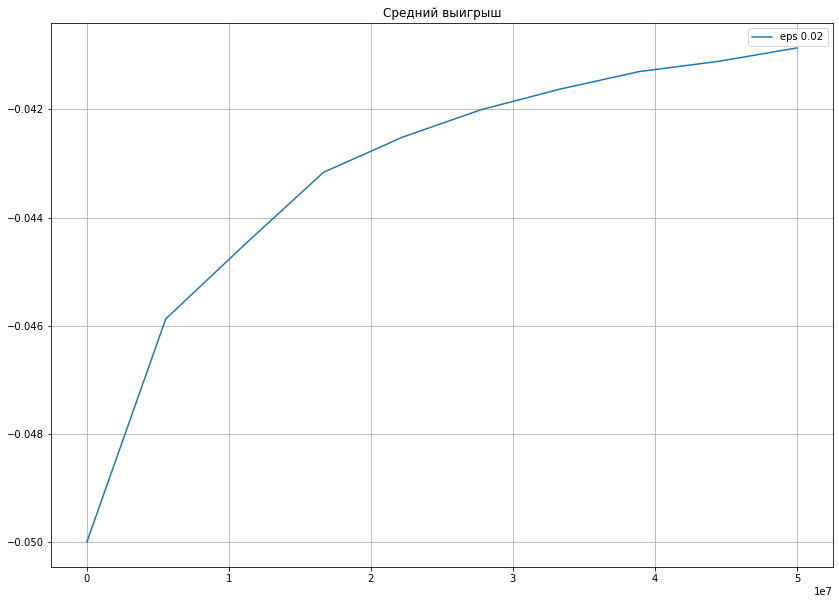

In [14]:
points = 10
x = np.linspace(0, num_experiments, points)
for eps in epsilons:
    plt.plot(x, reward_sum[eps], label='eps ' + str(eps))
plt.grid()
plt.legend()
plt.title('Cредний выигрыш')
plt.show()